In [82]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import rv_continuous


In [83]:
def p(x: np.ndarray) -> np.ndarray:
    """
    Compute the unnormalized target density function p(x).

    Parameters:
    x (np.ndarray): Input array of values.

    Returns:
    np.ndarray: Output array of the same shape as x, containing the computed density values.
    """
    px = np.exp(-(x**2) / 2) * (
        np.sin(x) ** 2 + 3 * np.cos(x) ** 2 * np.sin(7 * x) ** 2 + 1
    )
    # Set p(x) = 0 outside the interval [-3, 3]
    px = np.where(np.abs(x) <= 3, px, 0.0)
    return px


In [84]:
def compute_scaling_factor(
    p: Callable[[np.ndarray], np.ndarray], q: rv_continuous
) -> float:
    """
    Compute the scaling factor used in rejection sampling.

    Parameters:
    p (Callable[[np.ndarray], np.ndarray]): target density function. could be unnormalized
    q (rv_continuous): Proposal distribution from scipy.stats.

    Returns:
    float: The computed scaling factor.
    """
    x = np.linspace(-6, 6, 1000)

    # Evaluate p(x) and q(x) over x
    p_values = p(x)
    q_values = q.pdf(x)

    # Compute the scaling constant M used in rejection sampling
    # M = 1.1 * max(p(x) / q(x)) over the interval
    ratio_pq = np.divide(
        p_values, q_values, out=np.zeros_like(p_values), where=q_values != 0
    )
    M_estimate = np.max(ratio_pq)
    M = M_estimate * 1.01  # Slight overestimate to ensure p(x) ≤ M q(x)

    # print(f"Scaling constant M: {M}")

    return M


In [85]:
def plot_target_vs_proposal_distribution(
    p: Callable[[np.ndarray], np.ndarray], q: rv_continuous, name: str
):
    """
    Plots the target density function p(x) and the proposal density q(x) for visualization.

    Parameters:
    p (Callable[[np.ndarray], np.ndarray]): target density function. could be unnormalized
    q (rv_continuous): Proposal distribution from scipy.stats.
    name (str): Name of the proposal distribution. Used for printing the legend.
    """

    # Generate x-values over which to evaluate the functions
    x = np.linspace(-6, 6, 1000)

    # Evaluate p(x) and q(x) over x
    p_values = p(x)
    q_values = q.pdf(x)

    M = compute_scaling_factor(p, q)

    # Compute M * q(x)
    Mq_values = M * q_values

    # Plot the functions
    plt.figure(figsize=(10, 6))
    plt.plot(x, p_values, label="Unnormalized target density $p(x)$", color="blue")
    plt.plot(
        x,
        q_values,
        label="Normalized " + name + " proposal density $q(x)",
        color="red",
        linestyle="--",
    )
    plt.plot(
        x,
        Mq_values,
        label="Normalized Adjusted " + name + " proposal density $M q(x)",
        color="green",
        linestyle=":",
    )

    # Highlight the interval [-3, 3]
    plt.axvline(x=-3, color="gray", linestyle=":")
    plt.axvline(x=3, color="gray", linestyle=":")
    plt.fill_between(x, 0, p_values, where=(np.abs(x) > 3), color="blue", alpha=0.1)
    plt.fill_between(x, 0, q_values, where=(np.abs(x) > 3), color="red", alpha=0.1)

    plt.title("Comparison of target density $p(x)$ and proposal density $q(x)$")
    plt.xlabel("x")
    plt.ylabel("Density")
    # plt.legend(loc="upper right")
    plt.legend()
    plt.grid(False)
    plt.show()

In [112]:
def rejection_sampling(
    n_samples: int,
    target_dist: Callable[[np.ndarray], np.ndarray],
    proposal_dist: rv_continuous,
    batch_size: int = 100,
) -> np.ndarray:
    """
    Perform rejection sampling to generate samples from the target distribution.

    Parameters:
    n_samples (int): Number of samples to generate.
    target_dist (Callable[[np.ndarray], np.ndarray]): Unnormalized target density function.
    proposal_dist (rv_continuous): Proposal distribution from scipy.stats.

    Returns:
    np.ndarray: Array of generated samples.
    """
    M = compute_scaling_factor(target_dist, proposal_dist)

    batch_size = int(n_samples)

    samples = []
    while len(samples) < n_samples:
        # Sample x_candidate from the proposal distribution
        x_candidate = proposal_dist.rvs(size=batch_size)

        # Evaluate target_dist(x_candidate) and proposal_dist(x_candidate)
        p_x_candidate = target_dist(x_candidate)
        q_x_candidate = proposal_dist.pdf(x_candidate)

        # Compute acceptance probability
        acceptance_ratio = p_x_candidate / (M * q_x_candidate)

        # Generate a uniform random number u ∈ [0, 1)
        u = stats.uniform.rvs(size=batch_size)

        # Accept or reject the candidate sample
        accept = u < acceptance_ratio

        pct_rejected = np.sum(accept == False) / len(accept)

        accepted_x_batch = x_candidate[accept]

        # if u < acceptance_ratio:
        samples.extend(accepted_x_batch)

    return np.array(samples)

In [ ]:
def compute_expectation(p, q, n_samples, batch_size=100, verbose=True):
    samples = rejection_sampling(n_samples, p, q, batch_size=batch_size)
    E_x2 = np.mean(samples**2)
    if verbose:
        print(
            f"Estimated E[X^2] using rejection sampling: {E_x2:.4f} and samples: {n_samples}"
        )
    return E_x2

In [88]:
n_samples = 100000

In [89]:
uniform = stats.uniform(loc=-3, scale=6)


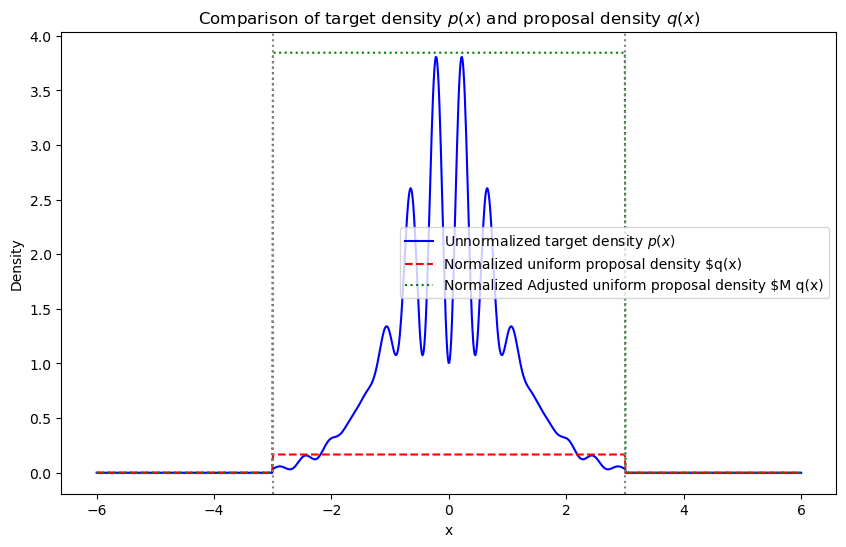

In [90]:
plot_target_vs_proposal_distribution(p, uniform, "uniform")

In [109]:
compute_expectation(p, uniform, n_samples)


Estimated E[X^2] using rejection sampling: 0.9343 and samples: 1000


0.9342700139720239

In [92]:
gaussian = stats.norm(loc=0, scale=1)

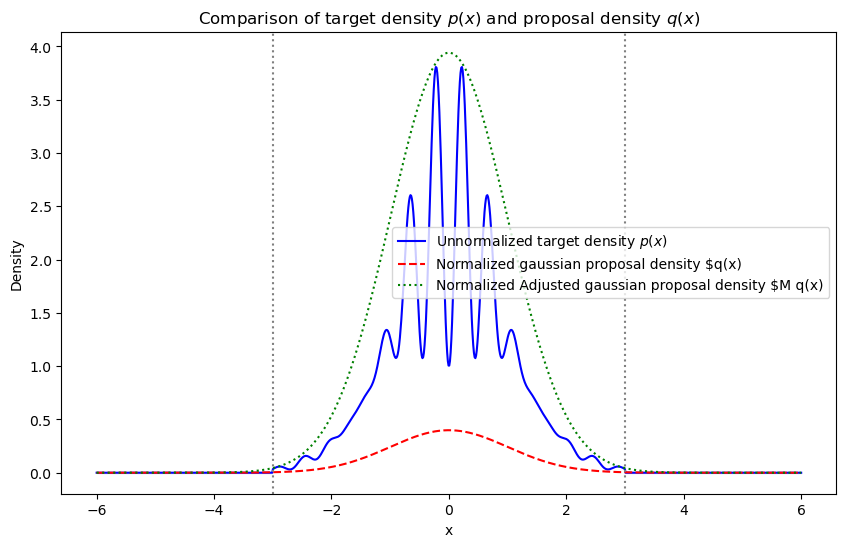

In [93]:
plot_target_vs_proposal_distribution(p, gaussian, "gaussian")

In [113]:
compute_expectation(p, gaussian, n_samples)

Estimated E[X^2] using rejection sampling: 0.9055 and samples: 1000


0.9055088008816677

In [95]:
str(uniform)

'<scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f03ab3288c0>'

In [96]:
number_of_samples = [10, 100, 1000]
proposal_distributions = [uniform, gaussian]
trials = 100

In [97]:
# Initialize an empty list to collect the data
data = []

In [104]:
for trial in range(trials):
    for n_samples in number_of_samples:
        for q in proposal_distributions:
            estimator = compute_expectation(
                p, q, n_samples, batch_size=n_samples, verbose=False
            )
            # Create a string representation of q
            q_repr = f"rejection sampling {q.dist.name}"
            data.append(
                {
                    "trial": trial,
                    "n_samples": n_samples,
                    "q_repr": q_repr,
                    "estimator": estimator,
                }
            )


In [105]:
def importance_sampling(p, q, num_samples: int = 10000) -> float:
    # Sample from the proposal distribution
    samples = q.rvs(size=num_samples)

    # Compute the unnormalized target density for these samples
    p_x = p(samples)

    # Compute the proposal density for these samples
    q_x = q.pdf(samples)

    # Compute the self-normalized weights
    weights = p_x / q_x
    weights /= np.sum(weights)  # Normalize the weights

    return weights, samples

In [106]:
q = stats.norm(loc=0, scale=1.5)

# Calculate the expectation
weights, samples = importance_sampling(p, q)
expectation = np.sum(weights * samples**2)
print("Expected value of x^2:", expectation)

Expected value of x^2: 0.9289456927273989


In [107]:
for trial in range(trials):
    for n_samples in number_of_samples:
        weights, samples = importance_sampling(p, q)
        estimator = np.sum(weights * samples**2)
        # Create a string representation of q
        q_repr = "importance sampling norm"
        data.append(
            {
                "trial": trial,
                "n_samples": n_samples,
                "q_repr": q_repr,
                "estimator": estimator,
            }
        )


In [108]:
# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Compute mean and standard deviation for each combination of n_samples and q
grouped = df.groupby(["n_samples", "q_repr"])["estimator"].agg(["mean", "std"])


print(grouped)

                                          mean       std
n_samples q_repr                                        
10        importance sampling norm    0.914833  0.010911
          rejection sampling norm     0.938798  0.397935
          rejection sampling uniform  0.919192  0.397832
100       importance sampling norm    0.915340  0.009907
          rejection sampling norm     0.908153  0.127851
          rejection sampling uniform  0.925322  0.117641
1000      importance sampling norm    0.916142  0.010801
          rejection sampling norm     0.913434  0.042452
          rejection sampling uniform  0.914219  0.040854
